In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
train_csv = 'data/sunspot_train.csv'
test_csv = 'data/sunspot_test.csv'

In [3]:
train_df = pd.read_csv(train_csv, index_col=0)
test_df = pd.read_csv(test_csv, index_col=0)

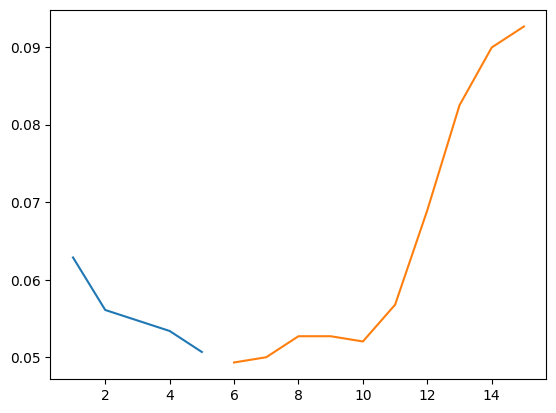

In [4]:
fig, ax = plt.subplots()

ts_input = np.array(range(1, 6))
X_train = train_df.loc[:, [f'Input{i}' for i in ts_input]].values
X_test = test_df.loc[:, [f'Input{i}' for i in ts_input]].values

ts_output = np.array(range(1, 11))
y_train = train_df.loc[:, [f'Output{i}' for i in ts_output]].values
y_test = test_df.loc[:, [f'Output{i}' for i in ts_output]].values

ts_output = ts_output + ts_input[-1]

ax.plot(ts_input, X_train[0])
ax.plot(ts_output, y_train[0])

In [5]:
def tilted_loss(q, y, f):
    e = (y-f)
    return torch.mean(torch.max(q*e, (q-1)*e))

In [6]:
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)

quantiles = [0.05, 0.25, 0.50, 0.75, 0.95]
quantile_loss = np.zeros(len(quantiles))

input_size = 5
hidden_size = 256
out_ts = 10
output_size = out_ts*len(quantiles)

lr = 1e-2
num_epochs = 5000

model = nn.Sequential(
            nn.Linear(input_size, output_size)
        ).double()

opt = torch.optim.Adam(model.parameters(), lr=lr)

In [7]:
quantile_loss = np.zeros(len(quantiles))

# Training loop
for epoch in range(num_epochs):

    # for j, (q, model, opt) in enumerate(zip(quantiles, models, opts)):

    model = model.train()

    # Zero the parameter gradients
    opt.zero_grad()

    # Forward pass
    y_pred = model(X_train_tensor)

    # Calculate loss
    loss = 0.0 
    for j, q in enumerate(quantiles):
        qloss = tilted_loss(q, y_train_tensor, y_pred[:, j*out_ts:min((j+1)*out_ts, output_size)])
        loss += qloss
        quantile_loss[j] = qloss.item()

    # Backward pass and optimization
    loss.backward()
    opt.step()
    
    # Print statistics
    print(f'[{epoch + 1}] loss: {quantile_loss}')
    # print('[%d] loss: %.3f' %
    #         (epoch + 1, running_loss))

print('Finished Training')

[1] loss: [0.06428872 0.11592089 0.21860557 0.36613512 0.45384976]
[2] loss: [0.05876441 0.10902914 0.20785887 0.34736477 0.4325443 ]
[3] loss: [0.05382428 0.10249475 0.19733065 0.3287398  0.41166963]
[4] loss: [0.04949558 0.09615285 0.18718619 0.31032249 0.39112585]
[5] loss: [0.0457327  0.09015285 0.17743302 0.29220183 0.37084424]
[6] loss: [0.04247142 0.08451589 0.16810204 0.27442186 0.35083498]
[7] loss: [0.03965037 0.07914222 0.15939095 0.25714932 0.33117558]
[8] loss: [0.03716073 0.07403053 0.15121355 0.24087111 0.31183413]
[9] loss: [0.03489772 0.06919364 0.14356431 0.22585131 0.29284812]
[10] loss: [0.0327954  0.06462059 0.13661435 0.21238476 0.27434869]
[11] loss: [0.03087005 0.0602518  0.13009676 0.20043975 0.25621868]
[12] loss: [0.02906489 0.05606699 0.12385407 0.18968885 0.23848107]
[13] loss: [0.02736657 0.05201639 0.11782163 0.17985587 0.22114157]
[14] loss: [0.02580139 0.04822546 0.11206073 0.17068918 0.20418021]
[15] loss: [0.02435287 0.04503862 0.10665533 0.16219101 0

In [8]:
y_pred_list = []
test_quantile_loss = np.zeros(len(quantiles))

X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

model = model.eval()
y_pred = model(X_test_tensor).reshape(-1, len(quantiles), out_ts)

for j, q in enumerate(quantiles):
    test_quantile_loss[j] = tilted_loss(q, y_test_tensor, y_pred[:, j])

y_pred = y_pred.detach().numpy()

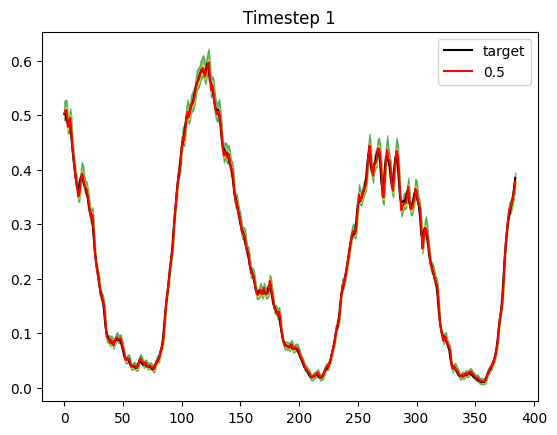

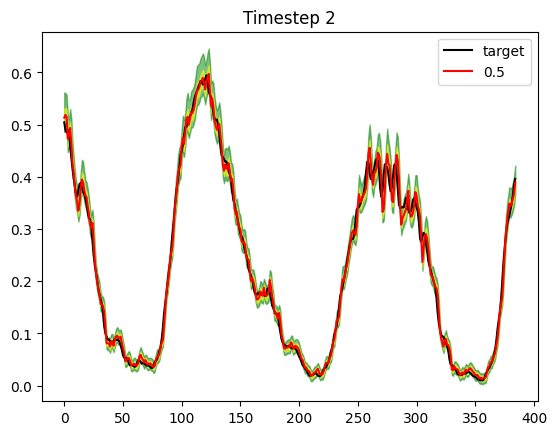

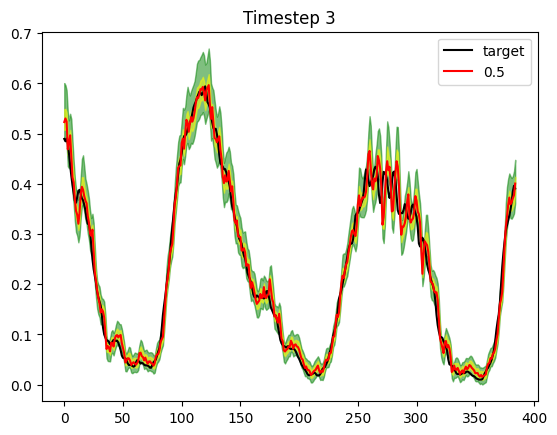

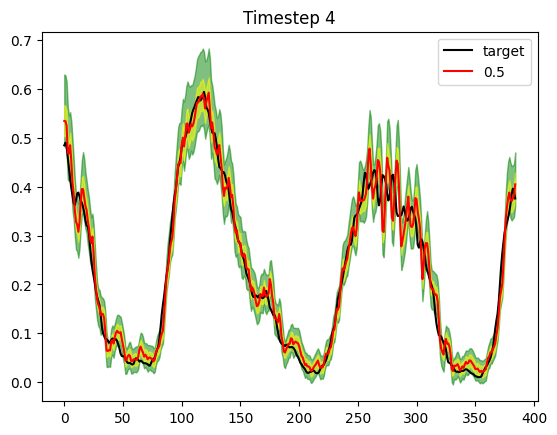

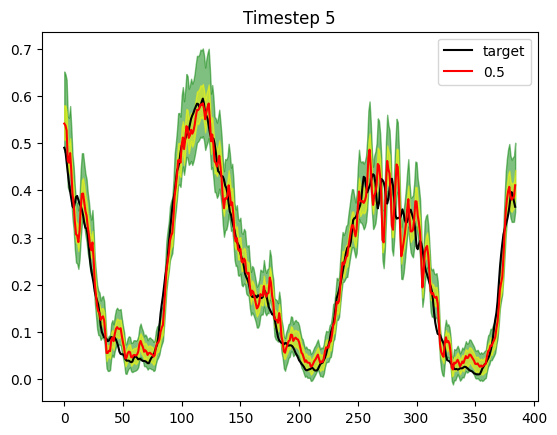

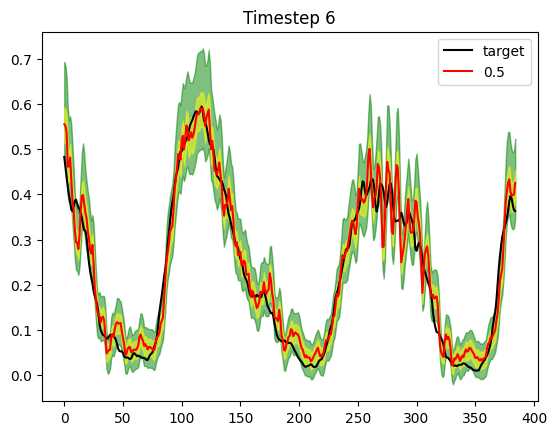

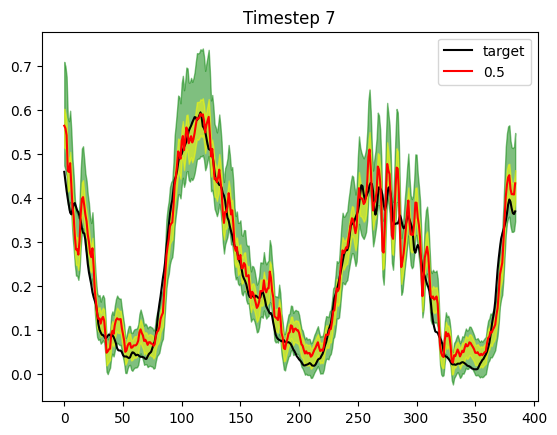

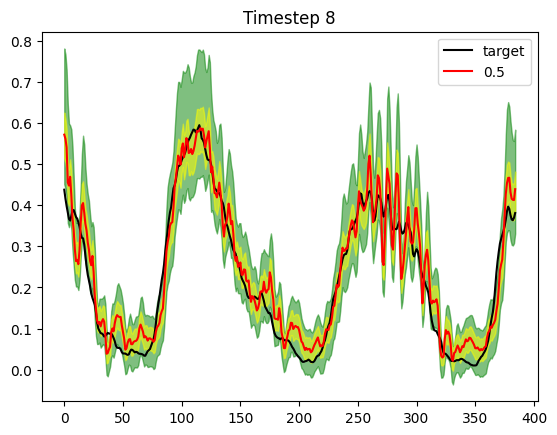

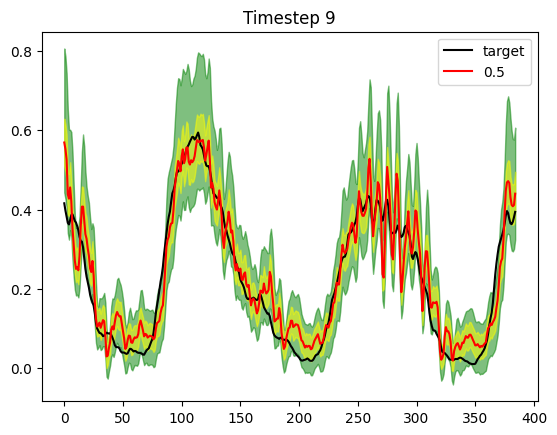

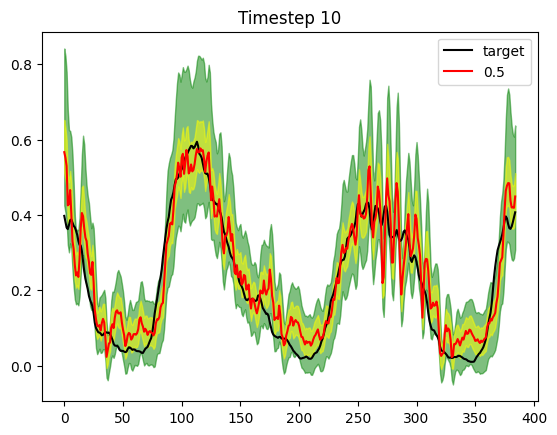

In [9]:
colors = ['green', 'orange', 'red', 'orange', 'green']

for ts in range(10):
    
    fig, ax = plt.subplots()
    ax.plot(y_test[:, ts], color='black', label='target')
    
    # for i, q in enumerate(quantiles):
    ax.plot(y_pred[:, 2, ts], color=colors[2], label=0.5)
    ax.fill_between(range(len(y_pred)),  y_pred[:, 0, ts], y_pred[:, -1, ts], alpha=0.5, color='green')
    ax.fill_between(range(len(y_pred)),  y_pred[:, 1, ts], y_pred[:, -2, ts], alpha=0.5, color='yellow')

    ax.set_title(f'Timestep {ts+1}')
    plt.legend()

In [10]:
test_quantile_loss

array([0.0032433 , 0.0104224 , 0.01387982, 0.01200244, 0.00455911])